Realizando importações

**ALUNOS:** **Felipe Versiane, Guilherme Sanches, Jônathas David**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score



Extraindo dados

In [ ]:
data=pd.read_csv("https://scanuto.com/IFG.csv", delimiter=", \"",
             names=['labels','texto'], skiprows=1, engine='python')
data.dropna(inplace=True)

data_texto= data['texto']
data_labels=data['labels']



Processando dados

In [ ]:
# Vetorização TF-IDF
vectorizer = TfidfVectorizer(
    lowercase=True,          # Converte tudo para minúsculas
    max_df=0.95,             # Remove palavras muito frequentes
    min_df=2,                # Remove palavras muito raras
    token_pattern=r'\b[a-zA-Zá-úÁ-Ú]{3,}\b',  # Apenas palavras com pelo menos 3 letras
    decode_error='ignore'
)
X = vectorizer.fit_transform(data_texto.tolist())

# 4️⃣ Divisão em treino e teste para todos
X_train, X_test, y_train, y_test = train_test_split(X, data_labels, test_size=0.2, random_state=42)

KNN


--- Melhores Hiperparâmetros Encontrados ---
{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Fold -> Acurácia: 0.5591 | Precisão: 0.5841 | Recall: 0.5163 | F1-score: 0.5298
Fold -> Acurácia: 0.6262 | Precisão: 0.6428 | Recall: 0.5579 | F1-score: 0.5623
Fold -> Acurácia: 0.5815 | Precisão: 0.6323 | Recall: 0.5365 | F1-score: 0.5511
Fold -> Acurácia: 0.5751 | Precisão: 0.6462 | Recall: 0.5111 | F1-score: 0.5168
Fold -> Acurácia: 0.5897 | Precisão: 0.5821 | Recall: 0.5428 | F1-score: 0.5500

--- Estatísticas da Validação Cruzada ---
Média da Acurácia: 0.5863 | Desvio Padrão: 0.0223
Média da Precisão: 0.6175 | Desvio Padrão: 0.0285
Média do Recall: 0.5329 | Desvio Padrão: 0.0172
Média do F1-score: 0.5420 | Desvio Padrão: 0.0164

--- Avaliação Final no Teste ---
Acurácia: 0.5765
Precisão: 0.5680
Recall: 0.5209
F1-score: 0.5315

--- Matriz de confusão  ---


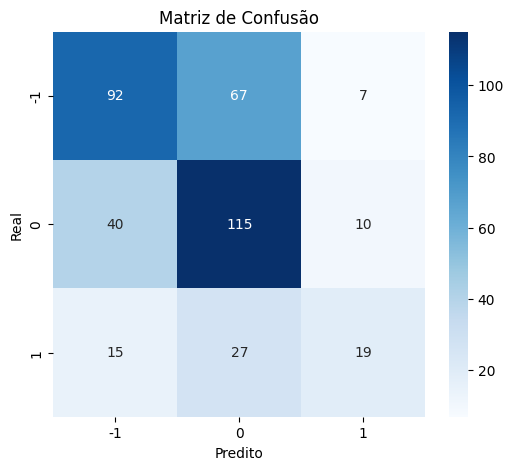

In [ ]:
# Definição do modelo KNN
knn = KNeighborsClassifier()

# Definição dos hiperparâmetros para busca
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

# Busca dos melhores hiperparâmetros com GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Melhor modelo encontrado
best_knn = grid_search_knn.best_estimator_

# Exibir os melhores hiperparâmetros
print("\n--- Melhores Hiperparâmetros Encontrados ---")
print(grid_search_knn.best_params_)

# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]  # Se for pandas Series

    # Treinamento do modelo no fold atual
    best_knn.fit(X_train_fold, y_train_fold)

    # Predição no conjunto de validação
    y_pred = best_knn.predict(X_val_fold)

    # Cálculo das métricas
    acc = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val_fold, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, average='macro', zero_division=0)

    # Armazena os valores das métricas
    acc_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f'Fold -> Acurácia: {acc:.4f} | Precisão: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}')

# Estatísticas das métricas
print("\n--- Estatísticas da Validação Cruzada ---")
print(f'Média da Acurácia: {np.mean(acc_scores):.4f} | Desvio Padrão: {np.std(acc_scores):.4f}')
print(f'Média da Precisão: {np.mean(precision_scores):.4f} | Desvio Padrão: {np.std(precision_scores):.4f}')
print(f'Média do Recall: {np.mean(recall_scores):.4f} | Desvio Padrão: {np.std(recall_scores):.4f}')
print(f'Média do F1-score: {np.mean(f1_scores):.4f} | Desvio Padrão: {np.std(f1_scores):.4f}')

# Avaliação final no conjunto de teste
y_test_pred = best_knn.predict(X_test)

final_accuracy_knn = accuracy_score(y_test, y_test_pred)
final_precision_knn = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
final_recall_knn = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
final_f1_knn = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print("\n--- Avaliação Final no Teste ---")
print(f'Acurácia: {final_accuracy_knn:.4f}')
print(f'Precisão: {final_precision_knn:.4f}')
print(f'Recall: {final_recall_knn:.4f}')
print(f'F1-score: {final_f1_knn:.4f}')

# Matriz de confusão
print("\n--- Matriz de confusão  ---")

conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

Árvore de Decisão


--- Melhores Hiperparâmetros Encontrados para Árvore de Decisão ---
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Fold -> Acurácia: 0.5399 | Precisão: 0.5337 | Recall: 0.5256 | F1-score: 0.5283
Fold -> Acurácia: 0.5751 | Precisão: 0.5583 | Recall: 0.5535 | F1-score: 0.5557
Fold -> Acurácia: 0.5080 | Precisão: 0.4915 | Recall: 0.4770 | F1-score: 0.4817
Fold -> Acurácia: 0.5591 | Precisão: 0.5398 | Recall: 0.5052 | F1-score: 0.5086
Fold -> Acurácia: 0.5096 | Precisão: 0.5009 | Recall: 0.4825 | F1-score: 0.4885

--- Estatísticas da Validação Cruzada ---
Média da Acurácia: 0.5383 | Desvio Padrão: 0.0266
Média da Precisão: 0.5248 | Desvio Padrão: 0.0249
Média do Recall: 0.5088 | Desvio Padrão: 0.0283
Média do F1-score: 0.5125 | Desvio Padrão: 0.0270

--- Avaliação Final no Teste ---
Acurácia: 0.4898
Precisão: 0.4719
Recall: 0.4592
F1-score: 0.4642


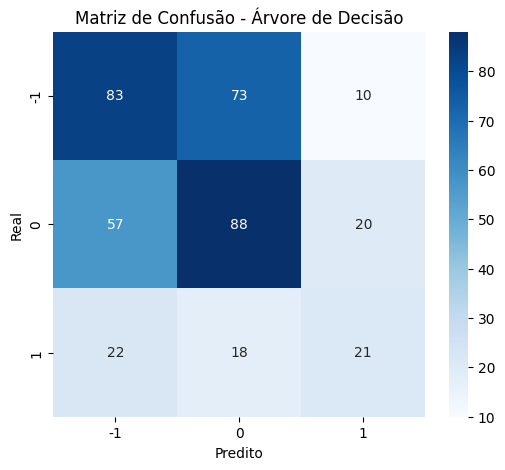

In [ ]:
# Definição dos hiperparâmetros para busca
param_grid_dt = {
    'criterion': ['gini', 'entropy'],  # Critério para dividir os nós
    'max_depth': [None, 10, 20, 30],   # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],   # Número mínimo de amostras para dividir um nó
}

# Criando o modelo Árvore de Decisão
dt = DecisionTreeClassifier(random_state=42)

# Aplicando o GridSearchCV com validação cruzada de 5 dobras
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Melhor modelo encontrado
best_dt = grid_search_dt.best_estimator_

# Exibir os melhores hiperparâmetros
print("\n--- Melhores Hiperparâmetros Encontrados para Árvore de Decisão ---")
print(grid_search_dt.best_params_)

# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]  # Se for pandas Series

    # Treinamento do modelo no fold atual
    best_dt.fit(X_train_fold, y_train_fold)

    # Predição no conjunto de validação
    y_pred = best_dt.predict(X_val_fold)

    # Cálculo das métricas
    acc = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val_fold, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, average='macro', zero_division=0)

    # Armazena os valores das métricas
    acc_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f'Fold -> Acurácia: {acc:.4f} | Precisão: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}')

# Estatísticas das métricas
print("\n--- Estatísticas da Validação Cruzada ---")
print(f'Média da Acurácia: {np.mean(acc_scores):.4f} | Desvio Padrão: {np.std(acc_scores):.4f}')
print(f'Média da Precisão: {np.mean(precision_scores):.4f} | Desvio Padrão: {np.std(precision_scores):.4f}')
print(f'Média do Recall: {np.mean(recall_scores):.4f} | Desvio Padrão: {np.std(recall_scores):.4f}')
print(f'Média do F1-score: {np.mean(f1_scores):.4f} | Desvio Padrão: {np.std(f1_scores):.4f}')

# Avaliação final no conjunto de teste
y_test_pred = best_dt.predict(X_test)

final_accuracy_dt = accuracy_score(y_test, y_test_pred)
final_precision_dt = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
final_recall_dt = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
final_f1_dt = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print("\n--- Avaliação Final no Teste ---")
print(f'Acurácia: {final_accuracy_dt:.4f}')
print(f'Precisão: {final_precision_dt:.4f}')
print(f'Recall: {final_recall_dt:.4f}')
print(f'F1-score: {final_f1_dt:.4f}')

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()

Random Forest


--- Melhores Hiperparâmetros Encontrados para Random Forest ---
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Fold -> Acurácia: 0.6070 | Precisão: 0.6685 | Recall: 0.5539 | F1-score: 0.5681
Fold -> Acurácia: 0.6294 | Precisão: 0.6925 | Recall: 0.5680 | F1-score: 0.5818
Fold -> Acurácia: 0.5527 | Precisão: 0.5983 | Recall: 0.4992 | F1-score: 0.5095
Fold -> Acurácia: 0.6102 | Precisão: 0.6732 | Recall: 0.5440 | F1-score: 0.5510
Fold -> Acurácia: 0.6250 | Precisão: 0.6361 | Recall: 0.5743 | F1-score: 0.5859

--- Estatísticas da Validação Cruzada ---
Média da Acurácia: 0.6049 | Desvio Padrão: 0.0274
Média da Precisão: 0.6537 | Desvio Padrão: 0.0331
Média do Recall: 0.5479 | Desvio Padrão: 0.0265
Média do F1-score: 0.5593 | Desvio Padrão: 0.0277

--- Avaliação Final no Teste ---
Acurácia: 0.5918
Precisão: 0.6186
Recall: 0.5190
F1-score: 0.5333


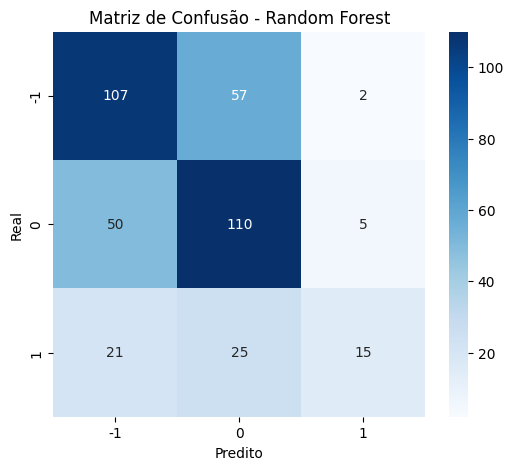

In [ ]:
# Definição dos hiperparâmetros para busca
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Número de árvores
    'max_depth': [10, 20, 30, None],  # Profundidade máxima
    'min_samples_split': [2, 5],      # Mínimo de amostras para dividir um nó
}

# Criando o modelo Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Aplicando o GridSearchCV com validação cruzada de 5 dobras
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Melhor modelo encontrado
best_rf = grid_search_rf.best_estimator_

# Exibir os melhores hiperparâmetros
print("\n--- Melhores Hiperparâmetros Encontrados para Random Forest ---")
print(grid_search_rf.best_params_)

# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]  # Se for pandas Series

    # Treinamento do modelo no fold atual
    best_rf.fit(X_train_fold, y_train_fold)

    # Predição no conjunto de validação
    y_pred = best_rf.predict(X_val_fold)

    # Cálculo das métricas
    acc = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val_fold, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, average='macro', zero_division=0)

    # Armazena os valores das métricas
    acc_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f'Fold -> Acurácia: {acc:.4f} | Precisão: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}')

# Estatísticas das métricas
print("\n--- Estatísticas da Validação Cruzada ---")
print(f'Média da Acurácia: {np.mean(acc_scores):.4f} | Desvio Padrão: {np.std(acc_scores):.4f}')
print(f'Média da Precisão: {np.mean(precision_scores):.4f} | Desvio Padrão: {np.std(precision_scores):.4f}')
print(f'Média do Recall: {np.mean(recall_scores):.4f} | Desvio Padrão: {np.std(recall_scores):.4f}')
print(f'Média do F1-score: {np.mean(f1_scores):.4f} | Desvio Padrão: {np.std(f1_scores):.4f}')

# Avaliação final no conjunto de teste
y_test_pred = best_rf.predict(X_test)

final_accuracy_rf = accuracy_score(y_test, y_test_pred)
final_precision_rf = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
final_recall_rf = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
final_f1_rf = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print("\n--- Avaliação Final no Teste ---")
print(f'Acurácia: {final_accuracy_rf:.4f}')
print(f'Precisão: {final_precision_rf:.4f}')
print(f'Recall: {final_recall_rf:.4f}')
print(f'F1-score: {final_f1_rf:.4f}')

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

In [ ]:
# Criando um dicionário com os dados
data = {
    "": ["kNN", "Árvore de decisão", "Random Forests"],
    "precisão": [" {:.2f}".format(final_precision_knn, 0.02),
                 " {:.2f}".format(final_precision_dt, 0.03),
                 " {:.2f}".format(final_precision_rf, 0.01)],
    "revocação": ["{:.2f}".format(final_recall_knn, 0.02),
                  "{:.2f}".format(final_recall_dt, 0.03),
                  "{:.2f}".format(final_recall_rf, 0.01)],
    "Acurácia": ["{:.2f}".format(final_accuracy_knn),
                 "{:.2f}".format(final_accuracy_dt),
                 "{:.2f}".format(final_accuracy_rf)],
    "MacroF1": ["{:.2f}".format(final_f1_knn),
                "{:.2f}".format(final_f1_dt),
                "{:.2f}".format(final_f1_rf)]
}

# Criando o DataFrame
df = pd.DataFrame(data)

# Exibindo a tabela
print(df)

                     precisão revocação Acurácia MacroF1
0                kNN     0.57      0.52     0.58    0.53
1  Árvore de decisão     0.47      0.46     0.49    0.46
2     Random Forests     0.62      0.52     0.59    0.53


#RESPOSTAS

*Acurácia*: Mede a proporção total de previsões corretas. O Random Forests obteve a melhor acurácia (0.59), seguido pelo kNN (0.58) e pela Árvore de Decisão (0.49). O bom desempenho do Random Forests ocorre pois acaba combinando múltiplas árvores para reduzir o erro e melhorar a generalização.

*Precisão*: Mede a proporção de verdadeiros positivos entre as previsões positivas. O Random Forests teve a maior precisão (0.62), o que indica que ele gera menos falsos positivos. O kNN ficou em segundo (0.57), e a Árvore de Decisão teve a menor precisão (0.47), indicando que pode estar classificando erroneamente muitas instâncias como positivas.

*Revocação* (Recall): Mede a proporção de instâncias positivas corretamente identificadas. O Random Forests e o kNN obtiveram valores iguais (0.52), o que significa que ambos capturam aproximadamente a mesma quantidade de exemplos positivos corretamente. Já a Árvore de Decisão teve um desempenho inferior (0.46), indicando que deixou escapar mais instâncias da classe positiva.

*Macro-F1* Score: Equilibra precisão e recall. O Random Forests e o kNN tiveram valores iguais (0.53), demonstrando um desempenho equilibrado. A Árvore de Decisão teve o pior resultado (0.46), mostrando que não consegue balancear bem precisão e recall.



Explicação do Melhor Desempenho do Random Forests
**negrito**
O Random Forests se destacou porque:

  Evita Overfitting: Diferente da Árvore de Decisão, ele utiliza múltiplas árvores para evitar que o modelo memorize os dados de treino, melhorando a generalização.
  Maior Robustez: Ele é menos sensível a outliers e ruídos nos dados, pois combina previsões de várias árvores.
  Equilíbrio Entre Precisão e Recall: Consegue capturar corretamente a maioria dos exemplos positivos sem gerar um excesso de falsos positivos.

O kNN teve um desempenho competitivo, mas pode ser afetado pela escolha do número de vizinhos e pela escala dos dados. Já a Árvore de Decisão teve o pior desempenho, pois tende a se ajustar excessivamente aos dados de treino (overfitting) ou ser muito simples se não estiver bem configurada.

Por fim, Random Forests é a melhor escolha para essa tarefa, pois apresenta o melhor desempenho em todas as métricas. O kNN também é uma opção viável, mas a Árvore de Decisão teve um desempenho inferior e pode não ser ideal para esse problema.